In [1]:
import numpy as np

In [2]:
M = ((-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1))

def calc_neighs(field, i, j):
    """
    Calculate number of neighbors alive (assuming square field)
    """
    neighs = 0
    n = len(field)
    for m in M:
        row_idx = m[0] + i
        col_idx = m[1] + j
        if 0 <= row_idx < n and 0 <= col_idx < n:
            if field[row_idx][col_idx]:
                neighs += 1
    return neighs

def make_move(field, moves=1):
    """
    Make a move forward according to Game of Life rules
    """
    n = len(field)
    cur_field = field
    for _ in range(moves):
        new_field = np.zeros((n, n), dtype='uint8')
        for i in range(n):
            for j in range(n):
                neighs = calc_neighs(cur_field, i, j)
                if cur_field[i][j] and neighs == 2:
                    new_field[i][j] = 1
                if neighs == 3:
                    new_field[i][j] = 1
        cur_field = new_field
    return cur_field

In [56]:
def generate_population(size, random_state=-1):
    """
    Generating initial population of individual solutions
    :return: initial population as a list of 20x20 arrays
    """
    if random_state != -1:
        np.random.seed(random_state)
    initial_states = np.split(np.random.binomial(1, 0.5, (20 * size, 20)).astype('uint8'), size)
    return [make_move(state, 5) for state in initial_states]

In [57]:
np.random.seed(42)
population = generate_population(10)

In [58]:
import matplotlib.pyplot as plt

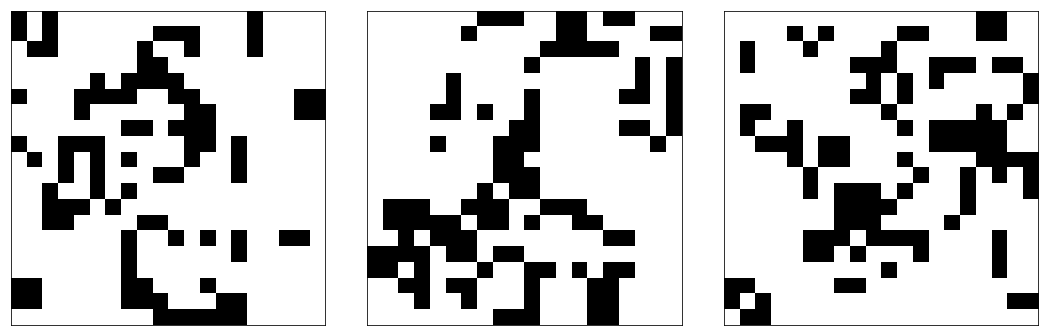

In [59]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
fig.tight_layout()
ax[0].set_xticks([], [])
ax[1].set_xticks([], [])
ax[2].set_xticks([], [])
ax[0].set_yticks([], [])
ax[1].set_yticks([], [])
ax[2].set_yticks([], []);
ax[0].imshow(population[0], cmap=plt.cm.Greys)
ax[1].imshow(population[1], cmap=plt.cm.Greys)
ax[2].imshow(population[2], cmap=plt.cm.Greys);
# fig.savefig('population_example.png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

In [7]:
def show_field(field):
    fig, ax = plt.subplots(figsize=(5, 5))
    fig.tight_layout()
    ax.set_xticks([], [])
    ax.set_yticks([], [])
    ax.imshow(field, cmap=plt.cm.Greys)
    return fig

In [60]:
def generate_problem():
    """ Generates example problem """
    np.random.seed(42)
    board = np.random.binomial(1, 0.01, (20, 20)).astype('uint8')
    # toad
    board[2, 3:6] = 1
    board[3, 2:5] = 1
    # glider 1
    board[9, 5:8] = 1
    board[8, 7] = 1
    board[7, 6] = 1
    # glider 2
    board[16, 3:6] = 1
    board[15, 5] = 1
    board[14, 4] = 1
    # beacon 1
    board[2:4, 14:16]=1
    board[4:6, 16:18]=1
    # beacon 2
    board[14:16, 14:16]=1
    board[16:18, 16:18]=1
    return board, make_move(board, 3)

In [130]:
X, Y = generate_problem()

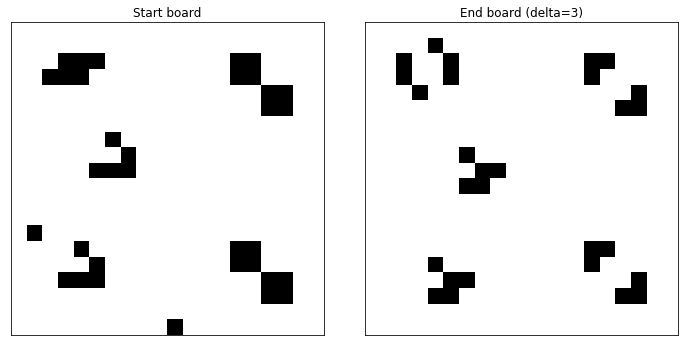

In [134]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
fig.tight_layout()
ax[0].set_xticks([], [])
ax[0].set_yticks([], [])
ax[1].set_xticks([], [])
ax[1].set_yticks([], [])
ax[0].imshow(X, cmap=plt.cm.Greys)
ax[0].set_title("Start board")
ax[1].imshow(Y, cmap=plt.cm.Greys)
ax[1].set_title("End board (delta=3)");
fig.savefig('problem_example.png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

In [135]:
def fitness(start_field, end_field, delta):
    """
    Calculate fitness for particular candidate (start configuration of the field)
    :param start_field: candidate (start configuration)
    :param end_field: target (stop configuration)
    :param delta: number of steps to proceed before comparing to stop configuration
    :return: value in range [0, 1] that indicates fractions of cells that match their state
    """
    candidate = make_move(start_field, moves=delta)
    return (candidate == end_field).sum() / 400

      
def score_population(population, target, delta):
    """
    Apply fitness function for each gene in a population
    :param population: list of candidate solutions
    :param target: 20x20 array that represents field in stopping condition
    :param delta: number of steps to revert
    :return: list of scores for each solution
    """
    return [fitness(gene, target, delta) for gene in population]

In [136]:
score_population(population, Y, 3)

[0.78249999999999997,
 0.77500000000000002,
 0.745,
 0.70250000000000001,
 0.755,
 0.81999999999999995,
 0.73999999999999999,
 0.84499999999999997,
 0.83499999999999996,
 0.77500000000000002]

In [137]:
def selection(population, scores, retain_frac=0.8, retain_random=0.05):
    """
    Apply selection operator to the population
    :param population: list of candidate solutions
    :param scores: list of score associated with each individual
    :param retain_frac: percent of top individuals to retain
    :param retain_random: chance of retaining sub-optimal individuals in the population
    """
    retain_len = int(len(scores) * retain_frac)
    sorted_indices = np.argsort(scores)[::-1]
    population = [population[idx] for idx in sorted_indices]
    selected = population[:retain_len]
    leftovers = population[retain_len:]

    for gene in leftovers:
        if np.random.rand() < retain_random:
            selected.append(gene)
    return selected

In [138]:
score_population(selection(population, score_population(population, Y, 3)), Y, 3)

[0.84499999999999997,
 0.83499999999999996,
 0.81999999999999995,
 0.78249999999999997,
 0.77500000000000002,
 0.77500000000000002,
 0.755,
 0.745]

In [139]:
def mutate(field, switch_frac=0.1):
    """ Inplace mutation of the provided field """
    a = np.random.binomial(1, switch_frac, size=(20, 20)).astype('bool')
    field[a] += 1
    field[a] %= 2
    return field

In [140]:
gene = np.copy(population[1])
gene_copy = np.copy(gene)
mutate(gene, 0.05)

array([[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1],
       [0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 1, 1, 0, 0,

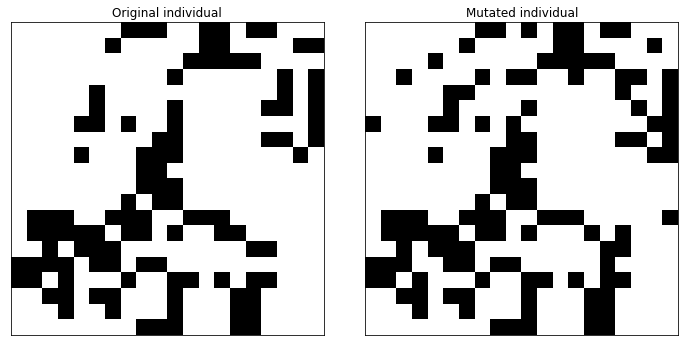

In [141]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
fig.tight_layout()
ax[0].set_xticks([], [])
ax[0].set_yticks([], [])
ax[1].set_xticks([], [])
ax[1].set_yticks([], [])
ax[0].imshow(gene_copy, cmap=plt.cm.Greys)
ax[0].set_title("Original individual")
ax[1].imshow(gene, cmap=plt.cm.Greys)
ax[1].set_title("Mutated individual");
fig.savefig('mutation_example.png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

In [142]:
def crossover(mom, dad):
    """ Take two parents, return two children, interchanging half of the allels of each parent randomly """
    select_mask = np.random.binomial(1, 0.5, size=(20, 20)).astype('bool')
    child1, child2 = np.copy(mom), np.copy(dad)
    child1[select_mask] = dad[select_mask]
    child2[select_mask] = mom[select_mask]
    return child1, child2

In [143]:
mom, dad = population[1], population[2]

In [144]:
child1, child2 = crossover(mom, dad)

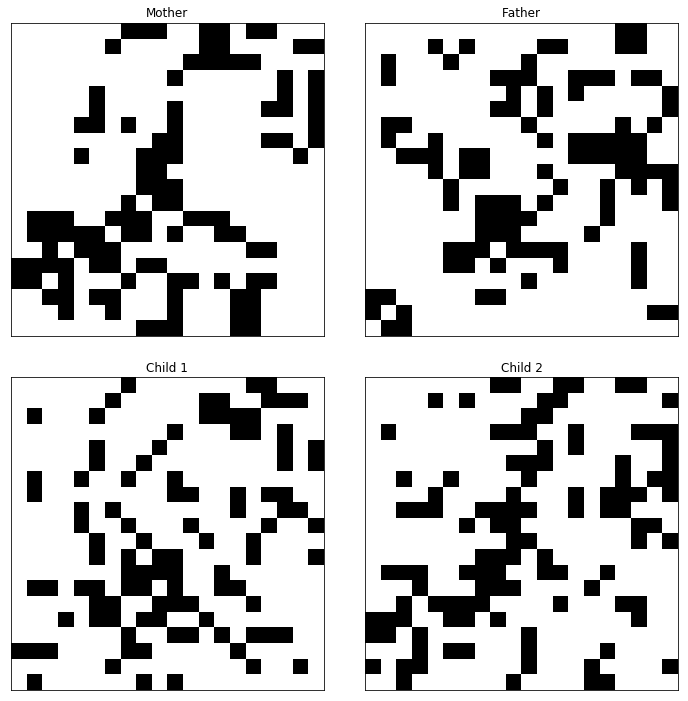

In [145]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
fig.tight_layout()
ax[0, 0].set_xticks([], [])
ax[0, 0].set_yticks([], [])
ax[0, 1].set_xticks([], [])
ax[0, 1].set_yticks([], [])
ax[1, 0].set_xticks([], [])
ax[1, 0].set_yticks([], [])
ax[1, 1].set_xticks([], [])
ax[1, 1].set_yticks([], [])
ax[0, 0].imshow(mom, cmap=plt.cm.Greys)
ax[0, 0].set_title("Mother")
ax[0, 1].imshow(dad, cmap=plt.cm.Greys)
ax[0, 1].set_title("Father");
ax[1, 0].imshow(child1, cmap=plt.cm.Greys)
ax[1, 0].set_title("Child 1")
ax[1, 1].imshow(child2, cmap=plt.cm.Greys)
ax[1, 1].set_title('Child 2');
fig.savefig('crossover_example.png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

In [146]:
def evolve(population, target, delta, retain_frac=0.8, retain_random=0.05, mutate_chance=0.05):
    """
    Evolution step
    :param Y: 20x20 array that represents field in stopping condition
    :param delta: number of steps to revert
    :return: new generation of the same size
    """
    scores = score_population(population, target, delta)
    next_population = selection(population, scores, retain_frac=retain_frac, retain_random=retain_random)
    
    # mutate everyone expecting for the best candidate
    for gene in next_population[1:]:
        if np.random.rand() < mutate_chance:
            mutate(gene)

    places_left = len(population) - len(next_population)
    children = []
    parent_max_idx = len(next_population) - 1
    while len(children) < places_left:
        mom_idx, dad_idx = np.random.randint(0, parent_max_idx, 2)
        if mom_idx != dad_idx:
            child1, child2 = crossover(next_population[mom_idx], next_population[dad_idx])
            children.append(child1)
            if len(children) < places_left:
                children.append(child2)
    next_population.extend(children)
    return next_population

In [147]:
next_gen = evolve(population, Y, 3)

In [148]:
def solve(target, delta, population_size=200, n_generations=300):
    """
    :param target: 20x20 array that represents field in stopping condition
    :param delta: number of steps to revert
    :param n_generations: number of evolution generations. Overrides initialization value if specified
    :return: 20x20 array that represents the best start field found and associated fitness value
    """
    population = generate_population(population_size)
    for generation in range(n_generations):
        population = evolve(population, target, delta)
        if generation == 0:
            print("Generation #: best score")
        elif generation % 50 == 0:
            print("Generation ", generation, ": ", fitness(population[0], target, delta))
    return population[0]

In [ ]:
result = solve(Y, 3, n_generations=1000)

Generation #: best score
Generation  50 :  0.9325
Generation  100 :  0.935
Generation  150 :  0.94
Generation  200 :  0.94
Generation  250 :  0.9425
Generation  300 :  0.9475
Generation  350 :  0.9475
Generation  400 :  0.9475


In [ ]:
from MPGeneticSolver import MPGeneticSolver

In [ ]:
mpgs = MPGeneticSolver(verbosity=1, early_stopping=False, n_generations=3000)

In [ ]:
solution = mpgs.solve(Y, 3, False)

In [ ]:
show_field(make_move(solution[0], 3));

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
fig.tight_layout()
ax[0, 0].set_xticks([], [])
ax[0, 0].set_yticks([], [])
ax[0, 1].set_xticks([], [])
ax[0, 1].set_yticks([], [])
ax[1, 0].set_xticks([], [])
ax[1, 0].set_yticks([], [])
ax[1, 1].set_xticks([], [])
ax[1, 1].set_yticks([], [])
ax[0, 0].imshow(X, cmap=plt.cm.Greys)
ax[0, 0].set_title("Target start field")
ax[0, 1].imshow(Y, cmap=plt.cm.Greys)
ax[0, 1].set_title("Target end field");
ax[1, 0].imshow(solution[0], cmap=plt.cm.Greys)
ax[1, 0].set_title("GA solution start field")
ax[1, 1].imshow(make_move(solution[0], 3), cmap=plt.cm.Greys)
ax[1, 1].set_title('GA solution end field');
fig.savefig('solution_example.png', dpi=100, bbox_inches = 'tight', pad_inches = 0)